# Harris corner detection

In [ ]:
#!pip install imageio
#!pip install utils
#!pip install conv
#!pip install scikit-image

In [48]:
from imageio import imread, imsave
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from skimage import io
import numpy as np
import conv

In [49]:
image = imread('./spine.png').astype(float)

In [50]:
def show(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')

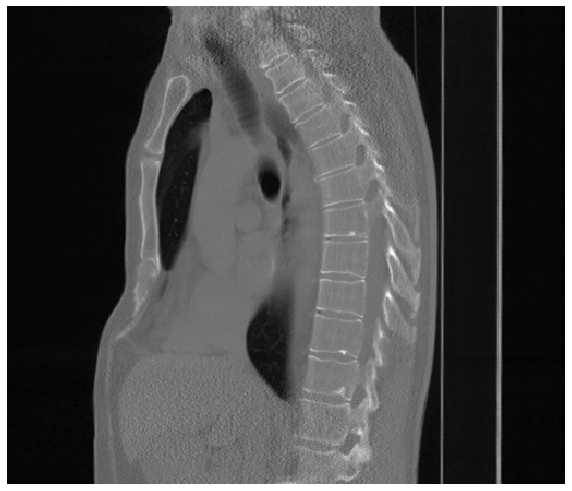

In [51]:
show(image)

### Градиент

In [52]:
gx, gy = np.gradient(image)

In [65]:
gxx = gx ** 2
gyy = gy ** 2
gxy = gx * gy

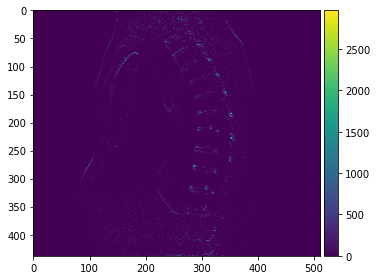

In [66]:
io.imshow(gxx)

### Матрица М

In [67]:
import scipy
from scipy import stats

def get_gaussian_kernel(size=17, nsig=3):
    x = np.linspace(-nsig, nsig, size + 1)
    kernel_1D = np.diff(stats.norm.cdf(x))
    
    kernel_2D = np.outer(kernel_1D, kernel_1D)
    kernel_2D_norm = kernel_2D / kernel_2D.sum()
    
    return kernel_2D_norm

In [68]:
kernel = get_gaussian_kernel()

In [69]:
from scipy.signal import convolve2d

In [70]:
mxx, myy, mxy = [convolve2d(x, kernel, mode='same') for x in [gxx, gyy, gxy]]

### Theta (corner response function)

In [71]:
alpha = 0.05
theta = (
    mxx * myy - mxy ** 2 # det
    - alpha *
    (mxx + myy) ** 2 # trace
)

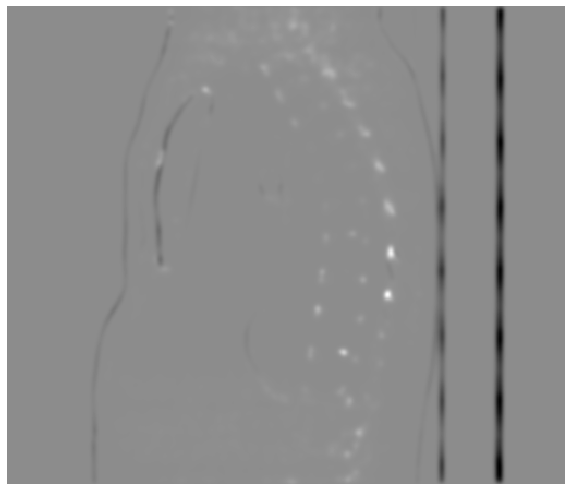

In [72]:
show(theta)

### Пороговое значение, поиск локальных максимумов

In [78]:
thresholded = theta > 5000

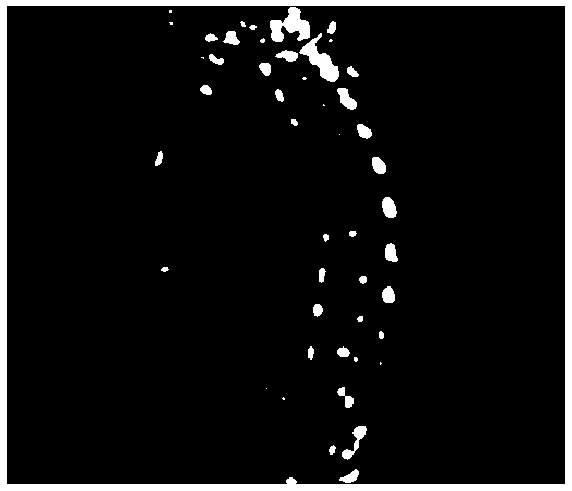

In [79]:
show(thresholded)

In [80]:
from skimage.measure import label

In [81]:
components = label(thresholded)

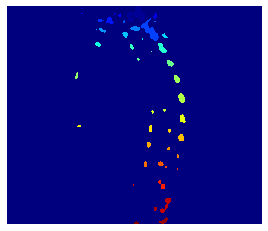

In [82]:
plt.imshow(components, cmap='jet')
plt.axis('off');

In [83]:
labels = np.unique(components)
labels = labels[1:] # drop the background

In [91]:
idx = np.argmax(theta * comp_mask)

In [85]:
indices = []

for component in labels:
    comp_mask = components == component
    
    idx = np.argmax(theta * comp_mask)
    
    # argmax returns a flat index, so make id 2D:
    idx = np.unravel_index(idx, theta.shape)
    indices.append(idx)
    
indices = np.array(indices)

ys, xs = indices.T

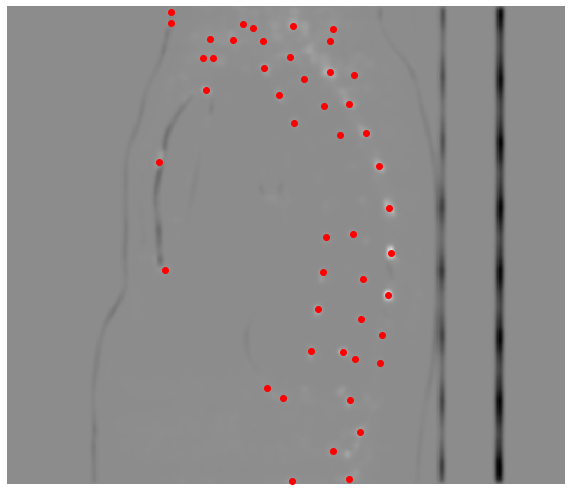

In [86]:
show(theta)
plt.scatter(xs, ys, c='r')

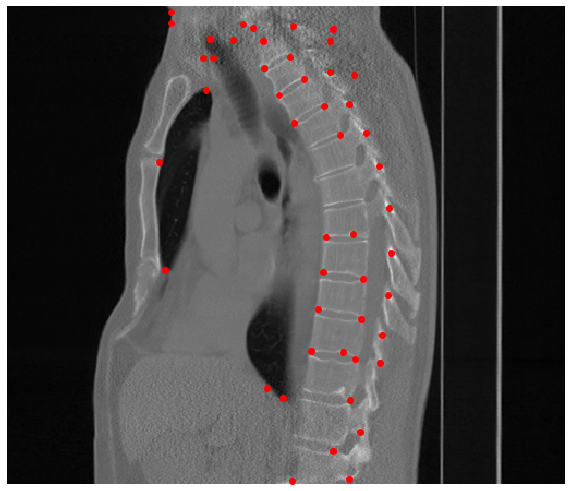

In [87]:
show(image)
plt.scatter(xs, ys, c='r')

# Собираем все вместе

In [90]:
def harris_theta(image, alpha=0.05, kernel_size=17):
    gx, gy = np.gradient(image)
    
    # outer product elements
    gxx = gx ** 2
    gyy = gy ** 2
    gxy = gx * gy
    
    kernel = get_gaussian_kernel(kernel_size)
    
    # matrix M components
    mxx, myy, mxy = [convolve2d(x, kernel, mode='same') for x in [gxx, gyy, gxy]]
    
    theta = (
        mxx * myy - mxy ** 2 # det
        - alpha *
        (mxx + myy) ** 2 # trace
    )
    
    return theta


def get_corners_indices(theta, threshold):
    components = label(theta > threshold)
    labels = np.unique(components)
    labels = labels[1:] # drop the background
    
    indices = []
    for component in labels:
        comp_mask = components == component

        idx = np.argmax(theta * comp_mask)

        # argmax returns a flat index, so make id 2D:
        idx = np.unravel_index(idx, theta.shape)
        indices.append(idx)

    indices = np.array(indices)

    ys, xs = indices.T
    return ys, xs

# Проверяем на инвариантность

In [94]:
translated = image[30:, 50:] # simplest translation

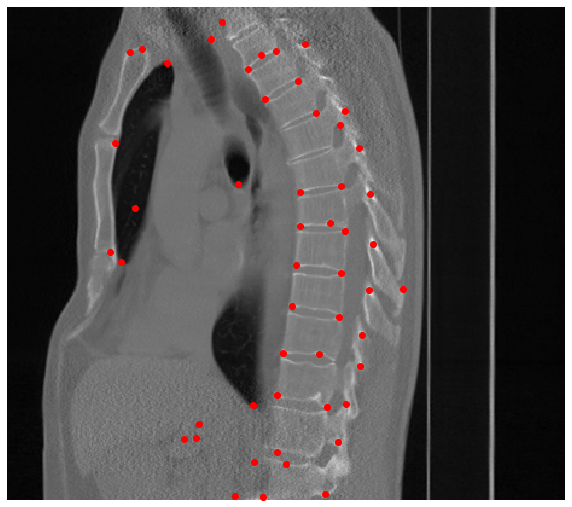

In [95]:
theta = harris_theta(translated)
th = 2000
ys, xs = get_corners_indices(theta, th)
show(translated)
plt.scatter(xs, ys, c='r')

## Поворот

In [96]:
from skimage.transform import rotate

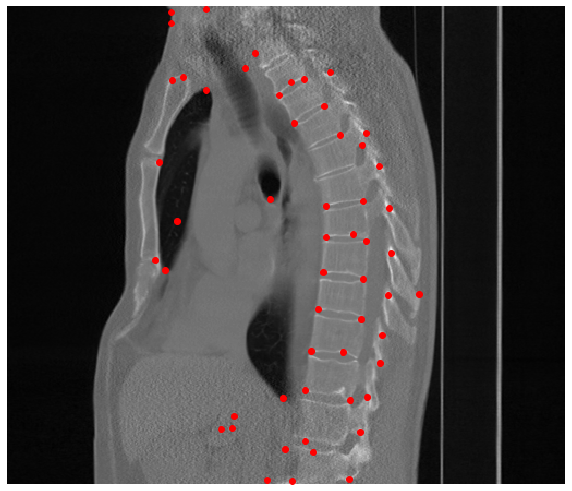

In [97]:
theta = harris_theta(image)
th = 2000
ys, xs = get_corners_indices(theta, th)
show(image)
plt.scatter(xs, ys, c='r')

In [98]:
rotated = rotate(image, 25)

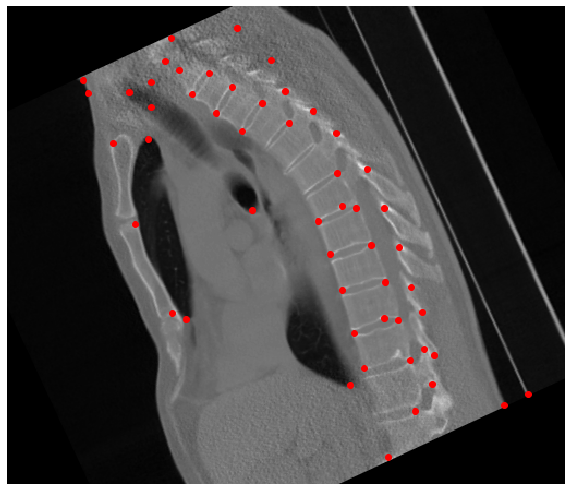

In [99]:
theta = harris_theta(rotated)
th = 2000
ys, xs = get_corners_indices(theta, th)
show(rotated)
plt.scatter(xs, ys, c='r')

Соответствие вполне сносное, хотя нектороые точки пропали. Почему так? Разве детектор Харриса не инвариантен к поворотам?

## Масштабирование

In [100]:
# the simplest scaling there is
scaled = image[::3, ::3]

In [102]:
image.shape

(438, 512)

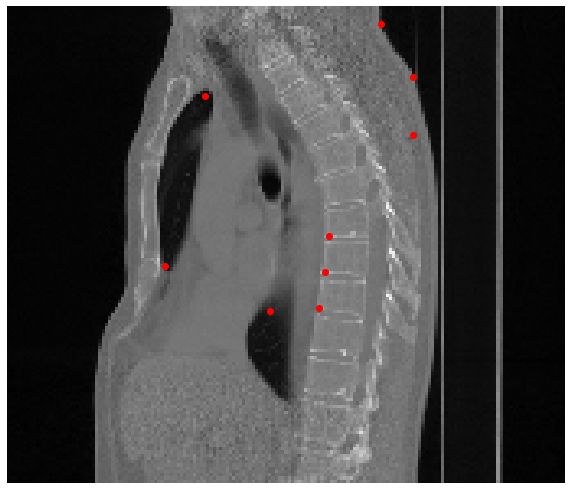

In [104]:
theta = harris_theta(scaled)
th = 2000
ys, xs = get_corners_indices(theta, th)
show(scaled)
plt.scatter(xs, ys, c='r')

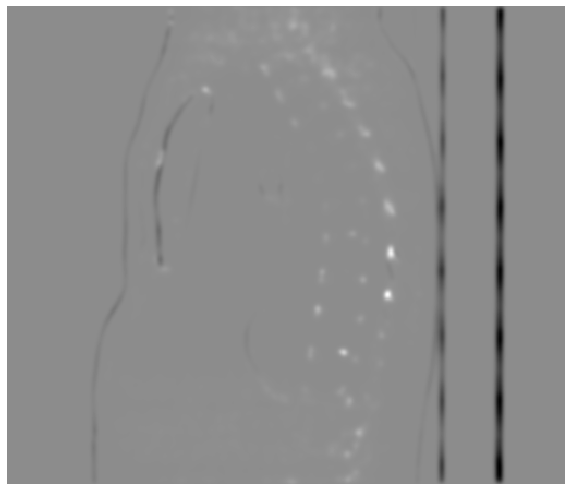

In [105]:
show(harris_theta(image))

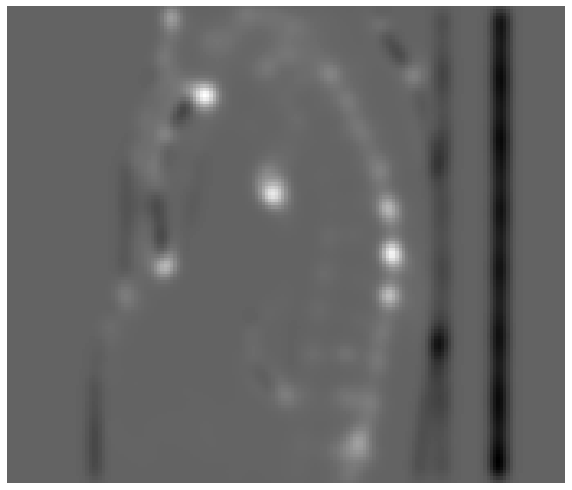

In [106]:
show(harris_theta(scaled))

Некоторые границы просто исчезли, поскольку фильтр Гаусса слишком большой для подобного масштаба.